In [1]:
from string2string.distance import LevenshteinEditDistance
from rwse import RWSE_Checker
from util.helper import check_token
from transformers import AutoTokenizer

import os
import pandas as pd
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
nlp = spacy.load('en_core_web_sm')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

## Cleaning

In [3]:
collection = dict()
with open('input/dataset_semantic_en_simple.txt', 'r') as f:
    result = []
    idx = 0
    for line in f:
        if line == "\n":
            collection[idx] = result
            idx += 1
            result = []
        else:
            result.append(line.strip())

len(collection)

448

In [4]:
collection[0]

['27',
 '1298315',
 'goals',
 'jails',
 '223',
 'Often they were sent away to the British Colonies in America. But in 1770, the colonies in America became the United States. They were free from British rule and would not take England s convicts any more. By the 1780s the goals of England were so full that convicts were often chained up in rotting old ships.The Government decided to make a settlement in New South Wales and send some of the convicts there. In 1788 the First Fleet of eleven ships set sail from Portsmouth carrying convicts, sailors, marines, a few free settlers and enough food to last for two years. Their leader was Captain Arthur Phillip.']

In [5]:
#file_name = 'input/cleaned_dataset_semantic_en.csv'
file_name = 'input/modified_dataset_semantic_en.csv'

def clean_text(text):
    text = '. '.join([part.strip() for part in text.split('.')]).strip()
    text = '. '.join([part.strip() for part in text.split('?')]).strip()
    return text

def find_sentence(token_text, token_start, text):
    tmp_doc = nlp(clean_text(text))
    for sent in tmp_doc.sents:
        if sent.start_char <= token_start < sent.end_char:
            for tmp_token in sent:
                if tmp_token.text == token_text:
                    tmp_start = tmp_token.idx - sent.start_char
                    tmp_end = tmp_start + len(tmp_token.text)
                    return sent.text[:tmp_start] + '[MASK]' + sent.text[tmp_end:]
    return None

if not os.path.exists(file_name):

    checkpoint = 'bert-base-cased'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    edit_distance = LevenshteinEditDistance()

    cleaned_collection_semantic = []
    bad_words = []
    bad_indices = []
    for key, value in collection.items():
        item = {
            'org_index': int(value[1]),
            'org_token': value[2],
            'org_suggestion': value[3],
            'confusion_set': f'{",".join(sorted([value[2],value[3]]))}',
            'levenshtein': edit_distance.compute(value[2], value[3]),
            'text': find_sentence(value[2], int(value[4]), ' '.join(value[5:]))
        }
        if check_token(tokenizer, item['org_token']) is None:
            bad_words.append(item['org_token'])
        elif check_token(tokenizer, item['org_suggestion']) is None:
            bad_words.append(item['org_suggestion'])
        elif item['text'] is None:
            bad_indices.append(item['org_index'])
        else:
            cleaned_collection_semantic.append(item)


    cleaned_collection_semantic = pd.DataFrame.from_dict(cleaned_collection_semantic)
    for confusion_set in cleaned_collection_semantic['confusion_set'].unique():
        indices = cleaned_collection_semantic[cleaned_collection_semantic['confusion_set'] == confusion_set].index
        if len(indices) == 2:
            cleaned_collection_semantic.drop(min(indices), inplace=True)
    cleaned_collection_semantic.to_csv(file_name, index=False, sep='\t')
    pd.DataFrame(bad_words).to_csv(file_name+'-bad_words', index=False, header=None, sep='\t')
    pd.DataFrame(bad_indices).to_csv(file_name+'-bad_indices', index=False, header=None, sep='\t')
else:
    cleaned_collection_semantic = pd.read_csv(file_name, sep='\t')

cleaned_collection_semantic

,org_index,org_token,org_suggestion,confusion_set,levenshtein,text
0,208822,were,wear,"wear,were",2.0,"When dancing ballet, you are required to [MASK..."
1,524374,affect,effect,"affect,effect",1.0,The Atlantic has a large [MASK] in the north a...
2,16804,work,word,"word,work",1.0,"Its name comes from the Greek [MASK] for Sun, ..."
3,341582,bitch,pitch,"bitch,pitch",1.0,There are four things which music often has Mu...
4,1250703,weed,wheat,"weed,wheat",3.0,One person who owned many cows could trade wit...
5,343890,art,part,"art,part",1.0,Leaving Canada Quebec was [MASK] of New France...
6,656168,mile,milk,"mile,milk",1.0,But still keeping the chocloate [MASK] away.
7,708056,crack,back,"back,crack",2.0,They also have a dark line down their [MASK].
8,103691,seal,meal,"meal,seal",1.0,"There is also informal education, for example,..."
9,350785,monkeys,monks,"monkeys,monks",2.0,History The first people who lived on Iceland ...


## Analysis

In [6]:
file_name = 'output/report_dataset_semantic_en.csv'

if not os.path.exists(file_name):
    with (open(file_name, 'w') as f):
        print('result', 'index' ,'org_token', 'org_suggestion', 'levenshtein', 'masked_sentence', 'certainty', sep='\t', end='\n', file=f)
        for index, item in cleaned_collection_semantic.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence)
            classification_result = 'TP' if suggestion == item['org_suggestion'] else 'FN'

            print(classification_result, item['org_index'], item['org_token'], item['org_suggestion'], item['levenshtein'], sentence, f'{certainty:.8f}', sep='\t', end='\n', file=f)

classification_results = pd.read_csv(file_name, sep='\t')
classification_results

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,208822,were,wear,2.0,"When dancing ballet, you are required to [MASK...",9.261138e-01
1,TP,524374,affect,effect,1.0,The Atlantic has a large [MASK] in the north a...,1.481276e-02
2,TP,16804,work,word,1.0,"Its name comes from the Greek [MASK] for Sun, ...",9.616073e-01
3,FN,341582,bitch,pitch,1.0,There are four things which music often has Mu...,9.500000e-07
4,FN,1250703,weed,wheat,3.0,One person who owned many cows could trade wit...,1.113100e-04
5,TP,343890,art,part,1.0,Leaving Canada Quebec was [MASK] of New France...,9.903137e-01
6,FN,656168,mile,milk,1.0,But still keeping the chocloate [MASK] away.,5.427000e-05
7,TP,708056,crack,back,2.0,They also have a dark line down their [MASK].,3.245256e-01
8,TP,103691,seal,meal,1.0,"There is also informal education, for example,...",3.224117e-02
9,TP,350785,monkeys,monks,2.0,History The first people who lived on Iceland ...,4.952400e-04


In [7]:
print('sensitivity', len(classification_results[classification_results['result'] == 'TP'])/len(classification_results))

sensitivity 0.8367346938775511


In [8]:
for value in sorted(classification_results['levenshtein'].unique()):
    current_df = classification_results[classification_results['levenshtein'] == value]
    print('levenshtein', value, 'sensitivity', len(current_df[current_df['result'] == 'TP'])/len(current_df))

levenshtein 1.0 sensitivity 0.8235294117647058
levenshtein 2.0 sensitivity 1.0
levenshtein 3.0 sensitivity 0.3333333333333333


### True-Positives

In [9]:
classification_results[classification_results['result'] == 'TP']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,208822,were,wear,2.0,"When dancing ballet, you are required to [MASK...",0.926114
1,TP,524374,affect,effect,1.0,The Atlantic has a large [MASK] in the north a...,0.014813
2,TP,16804,work,word,1.0,"Its name comes from the Greek [MASK] for Sun, ...",0.961607
5,TP,343890,art,part,1.0,Leaving Canada Quebec was [MASK] of New France...,0.990314
7,TP,708056,crack,back,2.0,They also have a dark line down their [MASK].,0.324526
8,TP,103691,seal,meal,1.0,"There is also informal education, for example,...",0.032241
9,TP,350785,monkeys,monks,2.0,History The first people who lived on Iceland ...,0.000495
11,TP,28378,king,kind,1.0,History of paper Many centuries ago as early a...,0.021355
12,TP,113165,effects,affects,1.0,Energy from the sun [MASK] the weather.,0.000420
14,TP,325250,whole,hole,1.0,You take it and put it in the groud and pick u...,0.047447


### False-Negatives

In [10]:
classification_results[classification_results['result'] == 'FN']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
3,FN,341582,bitch,pitch,1.0,There are four things which music often has Mu...,9.500000e-07
4,FN,1250703,weed,wheat,3.0,One person who owned many cows could trade wit...,1.113100e-04
6,FN,656168,mile,milk,1.0,But still keeping the chocloate [MASK] away.,5.427000e-05
10,FN,211968,steam,siege,3.0,Some of these machines were called catapults o...,3.355380e-02
13,FN,147342,castle,caste,1.0,"He would not keep his wife, his child, his wea...",1.921480e-03
22,FN,484398,cord,chord,1.0,It is a member of the [MASK] family.,1.790000e-06
34,FN,55424,mean,meal,1.0,"Sometimes, especially in the Southern United S...",1.756600e-04
42,FN,794884,fund,found,1.0,He left instructions in his will that his mone...,7.035944e-02


## Magnitue Search

<Axes: >

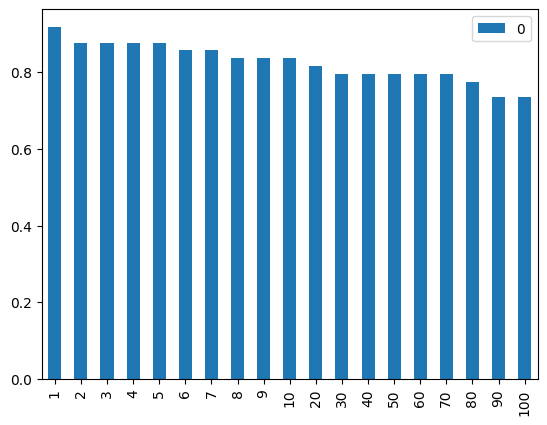

In [11]:
len_dataset = len(cleaned_collection_semantic)
magnitude_search = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
for i in ranges:
    count_TP = 0
    for index, item in cleaned_collection_semantic.iterrows():
        token = item['org_token']
        sentence = item['text']
        rwse.set_confusion_sets([item['confusion_set'].split(',')])
        suggestion, certainty = rwse.check(token, sentence, magnitude=i)
        if suggestion == item['org_suggestion']:
            count_TP += 1
    magnitude_search[i] = count_TP/len_dataset

pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar')
#pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar', subplots=True, layout=(1,2), figsize=(10,5))

<Axes: title={'center': 'model sensitivity by magnitude grouped by levenshtein edit distance'}>

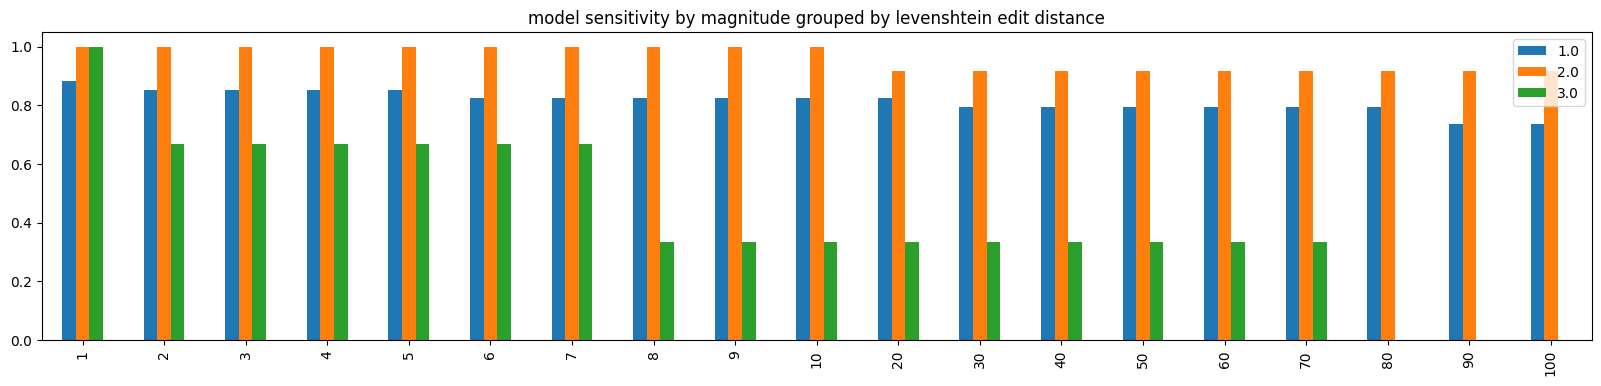

In [12]:
magnitude_search_dict = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
levenshtein_values = sorted(cleaned_collection_semantic['levenshtein'].unique())

for value in levenshtein_values:
    current_df = cleaned_collection_semantic[cleaned_collection_semantic['levenshtein'] == value]
    len_dataset = len(current_df)
    magnitude_search = dict()
    for i in ranges:
        count_TP = 0
        for index, item in current_df.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence, magnitude=i)
            if suggestion == item['org_suggestion']:
                count_TP += 1
        magnitude_search[i] = count_TP/len_dataset

    magnitude_search_dict[value] = magnitude_search.values()

tmp_df = pd.DataFrame({
    value: magnitude_search_dict[value] for value in levenshtein_values
}, index=ranges)
tmp_df.plot(kind="bar", figsize=(20,4), title=f'model sensitivity by magnitude grouped by levenshtein edit distance')
